In [1]:
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt

import tpot

In [2]:
RANDOM_SEED=1234

In [3]:
datapath = "../all_data_features.pkl"
all_data = pd.read_pickle(datapath)

In [4]:
all_data.drop(columns=["atoms_object (unitless)", "pymatgen_structure (unitless)"])
all_data = all_data[all_data["bandgap (eV)"] > 0.1]

In [6]:
all_data.head()

,Ac (atoms),Ac-Se (bonds),Ac-Se-Ac (angles),Ag (atoms),Ag-Ag (bonds),Ag-Ag-Ag (angles),Ag-Ag-Bi (angles),Ag-Ag-Br (angles),Ag-Ag-C (angles),Ag-Ag-Cl (angles),...,Zr-Zr-Sb (angles),Zr-Zr-Se (angles),Zr-Zr-Si (angles),Zr-Zr-Sn (angles),Zr-Zr-Te (angles),Zr-Zr-Zn (angles),Zr-Zr-Zr (angles),atoms_object (unitless),bandgap (eV),pymatgen_structure (unitless)
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Atom('Tl', [2.63896615613751, 10.292177253854...",0.9814,"[[ 2.63896616 10.29217725 11.08346956] Tl, [3...."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Atom('Ru', [0.0, 0.0, 0.0], index=0), Atom('I...",1.1619,"[[0. 0. 0.] Ru, [ 1.99801033 1.15354918 21.37..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Atom('Au', [0.0, 0.0, 3.8492055254399995], in...",0.1499,"[[0. 0. 3.84920553] Au, [2.239..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Atom('Si', [0.0, 0.0, 0.0], index=0), Atom('B...",0.2086,"[[0. 0. 0.] Si, [2.5703355 0. 0. ..."
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(Atom('Sr', [1.7335085, 1.7335085, 0.0], index...",2.9398,"[[1.7335085 1.7335085 0. ] Sr, [ 0. ..."


In [5]:
data_train, data_test = sklearn.model_selection.train_test_split(all_data.drop(columns=["atoms_object (unitless)", "pymatgen_structure (unitless)"]),
                                                                 random_state=RANDOM_SEED,
                                                                 test_size=0.2)

target = "bandgap (eV)"
train_x = data_train.drop(columns=[target]).to_numpy()
train_y = data_train[target].to_numpy()

test_x = data_test.drop(columns=[target]).to_numpy()
test_y = data_test[target].to_numpy()

# Stacked Ensemble
Same stacked ensemble developed in the thickness_coulomb notebook. Poor performance, but better than TPOT after 20 minutes.

In [23]:
import sklearn.ensemble
import sklearn.pipeline
import sklearn.impute
import sklearn.preprocessing
import sklearn.decomposition
import sklearn.linear_model
import sklearn.svm
import sklearn.neural_network
import sklearn.kernel_ridge

model = sklearn.pipeline.Pipeline(
    [("Imputation", sklearn.impute.KNNImputer()),
     ("Scaler", sklearn.preprocessing.StandardScaler()),
     ("PCA", sklearn.decomposition.PCA(n_components=128)),
     ("StackedEnsemble", sklearn.ensemble.StackingRegressor(
         estimators = [
             ('Lasso', sklearn.linear_model.LassoCV(tol=0.001)),
             ('Ridge', sklearn.linear_model.RidgeCV()),
             ('SVR', sklearn.svm.SVR(kernel='rbf',
                                     gamma='auto',
                                     C=1,
                                     epsilon=0.1)),
             ('GB', sklearn.ensemble.GradientBoostingRegressor(n_estimators=1000)),
             ('RF', sklearn.ensemble.RandomForestRegressor()),
             ('NN', sklearn.neural_network.MLPRegressor([200,200],
                                                         max_iter=1000)),
         ],
         final_estimator=sklearn.ensemble.GradientBoostingRegressor(n_estimators = 1000),
         cv=2,
         n_jobs=2)),
     ]
)
model.fit(train_x, train_y)

Pipeline(steps=[('Imputation', KNNImputer()), ('Scaler', StandardScaler()),
                ('PCA', PCA(n_components=128)),
                ('StackedEnsemble',
                 StackingRegressor(cv=2,
                                   estimators=[('Lasso', LassoCV(tol=0.001)),
                                               ('Ridge',
                                                RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                                               ('SVR', SVR(C=1, gamma='auto')),
                                               ('GB',
                                                GradientBoostingRegressor(n_estimators=1000)),
                                               ('RF', RandomForestRegressor()),
                                               ('NN',
                                                MLPRegressor(hidden_layer_sizes=[200,
                                                                                 200],
                                    

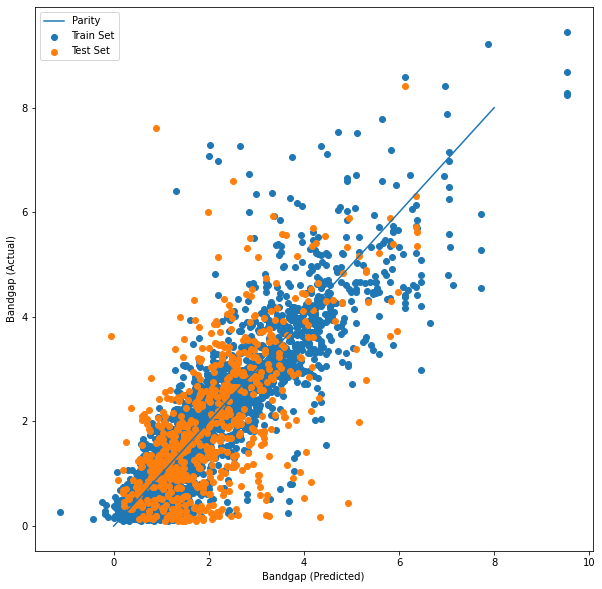

In [24]:
train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)

plt.rcParams['figure.figsize'] = [10,10]

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=test_y_pred, y=test_y, label="Test Set")
plt.plot([0,8], [0,8], label="Parity")
plt.ylabel("Bandgap (Actual)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()

# TPOT
Ran for 20 minutes. Poor results.

In [37]:
model = tpot.TPOTRegressor(
    generations=None,
    population_size=100,
    max_eval_time_mins=10/60,
    max_time_mins=20,
    cv=5,
    verbosity=2,
    scoring="r2",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=4,
    random_state=RANDOM_SEED
)
model.fit(features=train_x, target=train_y)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.3262118769575119

20.91 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=6, min_samples_leaf=15, min_samples_split=7)


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

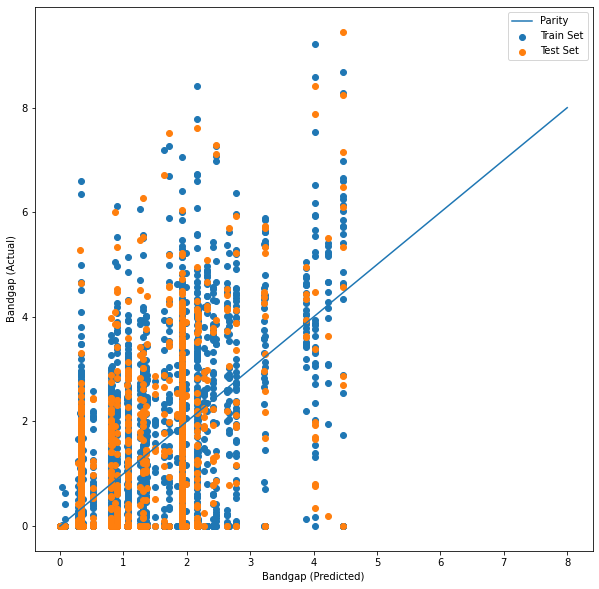

In [38]:
train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,10)

plt.scatter(x=train_y_pred, y=train_y, label="Train Set")
plt.scatter(x=test_y_pred, y=test_y, label="Test Set")
plt.plot([0,8], [0,8], label="Parity")
plt.ylabel("Bandgap (Actual)")
plt.xlabel("Bandgap (Predicted)")
plt.legend()